#**АИО. Лабораторная работа №2**

**Максимов Антон, 17ПМИ**

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from numpy import loadtxt
from scipy.optimize import linprog as simplex
from collections import deque
#from random import *
import random
import timeit

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
cd /content/gdrive/'My Drive'/АИО/benchmarks_knapsack/

/content/gdrive/My Drive/АИО/benchmarks_knapsack


In [0]:
a=!ls -1  *.*
capacity = []
weights= []
costs = []
answers = []

for i in range(0,27,4):
    capacity.append(int(loadtxt(a[i], comments="#", delimiter="\n", unpack=False)))
for i in range(1,27,4):
    costs.append(np.array((loadtxt(a[i], comments="#", delimiter="\n", unpack=False))).astype(int))
for i in range(2,27,4):
    answers.append(list(np.array((loadtxt(a[i], comments="#", delimiter="\n", unpack=False))).astype(int)))  
for i in range(3,28,4):
    weights.append(np.array((loadtxt(a[i], comments="#", delimiter="\n", unpack=False))).astype(int))        

In [347]:
capacity

[165, 26, 190, 50, 104, 170, 750]

In [8]:
weights

[array([23, 31, 29, 44, 53, 38, 63, 85, 89, 82]),
 array([12,  7, 11,  8,  9]),
 array([56, 59, 80, 64, 75, 17]),
 array([31, 10, 20, 19,  4,  3,  6]),
 array([25, 35, 45,  5, 25,  3,  2,  2]),
 array([41, 50, 49, 59, 55, 57, 60]),
 array([ 70,  73,  77,  80,  82,  87,  90,  94,  98, 106, 110, 113, 115,
        118, 120])]

In [9]:
costs

[array([92, 57, 49, 68, 60, 43, 67, 84, 87, 72]),
 array([24, 13, 23, 15, 16]),
 array([50, 50, 64, 46, 50,  5]),
 array([70, 20, 39, 37,  7,  5, 10]),
 array([350, 400, 450,  20,  70,   8,   5,   5]),
 array([442, 525, 511, 593, 546, 564, 617]),
 array([135, 139, 149, 150, 156, 163, 173, 184, 192, 201, 210, 214, 221,
        229, 240])]

In [10]:
answers

[[1, 1, 1, 1, 0, 1, 0, 0, 0, 0],
 [0, 1, 1, 1, 0],
 [1, 1, 0, 0, 1, 0],
 [1, 0, 0, 1, 0, 0, 0],
 [1, 0, 1, 1, 1, 0, 1, 1],
 [0, 1, 0, 1, 0, 0, 1],
 [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]]

##**Простая эвристика**

In [0]:
def Simple_Heuristic(capacity, weights, costs):
    quality = [cost / weight for cost, weight in zip(costs, weights)]
    n = len(weights)
    knapsack = [0]*n 
    old_index = [i for i in enumerate(quality)]
    index = sorted(old_index, key = lambda x:x[1], reverse=True)
    weight = 0
    for i in index:
        if weight + weights[i[0]] <= capacity:
          knapsack[i[0]] = 1
          weight += weights[i[0]]
        if weight == capacity:
          break  
    return knapsack      

In [27]:
Simple_Heuristic(capacity[0], weights[0], costs[0])

[0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0]

In [0]:
answers[0]

[1, 1, 1, 1, 0, 1, 0, 0, 0, 0]

##**Методом динамического программирования**

In [0]:
def Dynamic(capacity, weights, costs):
    n = len(weights)
    knapsack = [0]*n 
    table = [[0] * (capacity+1) for i in range(n+1)]

    for i in range(1, n+1): 
        for w in range(1, capacity+1): 
            if weights[i-1] <= w:
                table[i][w] = max(costs[i-1] + table[i-1][w - weights[i-1]], table[i-1][w])
            else:
                table[i][w] = table[i-1][w] 
    optimal_cost = table[n][capacity]
    i = n
    j = capacity
    while optimal_cost > 0:
        if table[i][j] == table[i - 1][j]:
            i -= 1
        else:
            knapsack[i - 1] = 1  
            optimal_cost -= costs[i - 1] 
            j = table[i - 1].index(optimal_cost)
            i -= 1

    return knapsack

In [0]:
Dynamic(capacity[1], weights[1], costs[1])

[0, 1, 1, 1, 0]

In [0]:
answers[1]

[0, 1, 1, 1, 0]

##**Методом ветвей и границ**

In [0]:
class Branch_and_Bound:
    def __init__(self, capacity, weights, costs):
        self.n = len(weights)   
        self.capacity = np.asarray(capacity).reshape(1, 1)
        self.weights = np.asarray(weights).reshape(1, self.n)
        self.costs = np.asarray(costs)
        self.nodes = []
        self.knapsack = [0]*self.n 
        self.current_best = 0
        self.best_solution = None
        self.best_value = -np.inf   
        self.root = None       
        self.subproblems = deque([(np.zeros((1, self.n)), np.zeros((1, 1)))])

    def run(self):
        while self.subproblems:

            A_parent, B_parent = self.subproblems.popleft()
            res = simplex(-self.costs, self.weights, self.capacity, A_parent, B_parent, method='revised simplex', bounds=(0,1))

            if not res.success:
              if res.status == 1:
                print("ERRORE")
              elif res.status == 2:
                continue  
              else:
                print("What`s wrong with you?")

            res.x[np.isclose(res.x, 0)] = 0
            #print(-res.fun)
        
            if -res.fun <= self.best_value:
                continue  
            
        
            fracts = []
            for i in range(len(res.x)):
                if not res.x[i].is_integer():
                    fracts.append(i)
        
            if not fracts:
                self.best_solution = res.x.astype('int')
                self.best_value = int(-res.fun)
                continue

            perem = max(fracts, key=abs)
            branch_i = perem

            left = np.floor(res.x[branch_i]) #0
            constrain_1 = np.zeros((1, self.n))
            constrain_1[0, branch_i] = 1 #добавляем по какой переменной идем

            A_child_1 = np.concatenate([A_parent, constrain_1]) 
            B_child_1 = np.concatenate([B_parent, np.array([[left]])])
            self.subproblems.append((A_child_1, B_child_1))

            right = np.ceil(res.x[branch_i])  #1
            constrain_2 = np.zeros((1, self.n))
            constrain_2[0, branch_i] = 1 #добавляем по какой переменной идем
            A_child_2 = np.concatenate([A_parent, constrain_2])
            b_child_2 = np.concatenate([B_parent, np.array([[right]])])
            self.subproblems.append((A_child_2, b_child_2))

        return self.best_solution
        

In [0]:
c = [6, 10, 10]
w = [1, 2, 3]
cap = 5

In [404]:
Branch_and_Bound(capacity[6], weights[6], costs[6]).run()

array([1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1])

In [405]:
answers[6]

[1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]

In [402]:
Branch_and_Bound(cap, w, c).run()

22.666666666666668
16.0
21.0
16.0
20.0


array([0, 1, 1])

**Вроде, сходится с тем, что было в презентации**

##**Генетическим алгоритмом**

In [373]:
answers[6]

[1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]

In [385]:
Genetic_Algorithm(capacity[6], weights[6], costs[6])

[1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]

In [0]:
def Genetic_Algorithm(capacity, weights, costs):
  n_items = len(costs)
  population_size = n_items*10
  generations = n_items*10
  knapsack = evolution(costs, weights, capacity, population_size, 100, generations, 0.6)
  return knapsack

In [0]:
def evolution(costs, weights, capacity, population_size, chance_of_mutate, generations, acceptance):
    generation = 0
    population = intialize_population(population_size, len(costs))

    fitness = fitness_function(population, costs, weights, len(costs), capacity)

    while(not is_converged(fitness,acceptance) and generation < generations):
        generation += 1
        population = generate_next_generation(population, fitness, len(costs), chance_of_mutate)
        fitness = fitness_function(population, costs, weights, len(costs), capacity)

    return get_solution(population,fitness)

In [0]:
def get_solution(population,fitness):
    best = 0
    for i,cur_fitness in enumerate(fitness):
        if cur_fitness > fitness[best]:
            best = i
    return population[best]

In [0]:
def intialize_population(population_size, n_items):
    population = []
    for i in range(population_size):
        population.append([])
        for j in range(n_items):
            if random.random() < 0.5:
                population[i].append(1)
            else:
                population[i].append(0)
    return population   

In [0]:
def selection(population,fitness):
    target_fitness = random.randint(0,sum(fitness))
    temp_sum = 0
    parent1 = []
    fitness1 = 0
    selected = ([],[])
    for i in range(0,len(population)):
        temp_sum += fitness[i]

        if temp_sum >= target_fitness:
            parent1 = population.pop(i)
            fitness1 = fitness.pop(i)
            break
    temp_sum = 0
    target_fitness = random.randint(0,sum(fitness))

    for i in range(0,len(population)):
        temp_sum += fitness[i]
        if temp_sum >= target_fitness:
            parent2 = population[i]
            population.append(parent1)
            fitness.append(fitness1)
            selected = (parent1,parent2)
            break

    return selected

In [0]:
def fitness_function(population, costs, weights, n_items, capacity):
    fitness = []
    for j,chromosome in enumerate(population):
        while True:
            cur_weight = 0
            cur_value = 0
            for i in range(0,n_items):
                if chromosome[i] != 0:
                    cur_weight += weights[i]
                    cur_value  += costs[i]
            if cur_weight <= capacity:
                fitness.append(cur_value)
                break
            else:
                remove = random.randint(0,n_items-1)
                chromosome[remove] = 0
        population[j] = chromosome
    return fitness

In [0]:
def is_converged(fitness, acceptance):
    mode_fitness = max(set(fitness),key=fitness.count)
    if float(fitness.count(mode_fitness)) / float(len(fitness)) >= acceptance:
        return True
    return False

In [0]:
def crossover(parent1,parent2,n_items):
    pivot = random.randint(0,n_items-1)
    child = (parent1[:pivot]) + (parent2[pivot:])
    return child

def mutate(chromosome,n_items,chance_of_mutate):
    for i in range(0,n_items - 1):
        mutation_cofficient = random.randint(1,chance_of_mutate)
        if mutation_cofficient == 1:
            chromosome[i] ^= 1
    return chromosome

In [0]:
def generate_next_generation(population, fitness, n_items, chance_of_mutate):
    population_size = len(fitness)
    new_population = [ get_solution(population,fitness) ]
    while(len(new_population) < population_size):
        (parent1, parent2) = selection(population,fitness)
        new_population.append(mutate(crossover(parent1,parent2,n_items),n_items,chance_of_mutate))
    return new_population

##**Тестирование**

**На первом датасете:**

In [0]:
Simple = []
for test in range(0, 7):
  Simple.append(np.mean(timeit.repeat("Simple_Heuristic(capacity[{0}], weights[{0}], costs[{0}])".format(test), setup="from __main__ import Simple_Heuristic, capacity, weights, costs", repeat = 100, number = 1)))

In [0]:
Dyn = []
for test in range(0, 7):
  Dyn.append(np.mean(timeit.repeat("Dynamic(capacity[{0}], weights[{0}], costs[{0}])".format(test), setup="from __main__ import Dynamic, capacity, weights, costs", repeat = 100, number = 1)))

In [0]:
Bnb = []
for test in range(0, 7):
  Bnb.append(np.mean(timeit.repeat("Branch_and_Bound(capacity[{0}], weights[{0}], costs[{0}]).run()".format(test), setup="from __main__ import Branch_and_Bound, capacity, weights, costs", repeat = 100, number = 1)))

In [0]:
Gen = []
for test in range(0, 7):
  Gen.append(np.mean(timeit.repeat("Genetic_Algorithm(capacity[{0}], weights[{0}], costs[{0}])".format(test), setup="from __main__ import Genetic_Algorithm, capacity, weights, costs", repeat = 100, number = 1)))

In [422]:
df = pd.DataFrame({
'Алгоритм': ['Простая эвристика', 'Методом динамического программирования', 'Методом ветвей и границ', 'Генетическим алгоритмом'],
'p01': [Simple[0], Dyn[0], Bnb[0], Gen[0]],
'p02': [Simple[1], Dyn[1], Bnb[1], Gen[1]],
'p03': [Simple[2], Dyn[2], Bnb[2], Gen[2]],
'p04': [Simple[3], Dyn[3], Bnb[3], Gen[3]],
'p05': [Simple[4], Dyn[4], Bnb[4], Gen[4]],
'p06': [Simple[5], Dyn[5], Bnb[5], Gen[5]],
'p07': [Simple[6], Dyn[6], Bnb[6], Gen[6]],
'Среднее время по всему датасету': [np.mean(Simple), np.mean(Dyn),np.mean(Bnb), np.mean(Gen)]
})
df

,Алгоритм,p01,p02,p03,p04,p05,p06,p07,Среднее время по всему датасету
0,Простая эвристика,0.000025,0.000012,0.000012,0.000014,0.000016,0.000013,0.000025,0.000016
1,Методом динамического программирования,0.001814,0.000149,0.001310,0.000401,0.001002,0.001341,0.013956,0.002853
2,Методом ветвей и границ,0.036755,0.049931,0.040780,0.023326,0.057631,0.262671,4.292766,0.680551
3,Генетическим алгоритмом,0.467620,0.039761,0.054071,0.080719,0.392123,0.204887,2.460195,0.528482


**Замечание 1: генетический может быстрее, но нужно уменьшить кол-во поколений или популяцию, что сильно сказывается на точности (или вручную настраивать)**\
**Замечание 2: простая эвристика быстрая, но туповатая, мало правильных ответов**

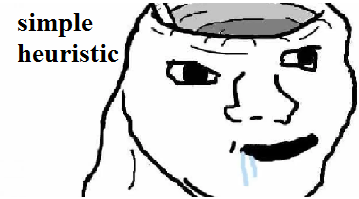

**На втором датасете**

**low-dimensional**

In [17]:
cd /content/gdrive/'My Drive'/АИО/low-dimensional/

/content/gdrive/My Drive/АИО/low-dimensional


In [0]:
a=!ls -1 *.*
new = []
for i in range(0,10):
  new.append(a[i][(a[i].find('kp_')+3):a[i].find('.')])
capacity = []
n_items = []
for i in range(0,10):
  n_items.append(int(new[i][0:new[i].find('_')]))
  capacity.append(int(new[i][new[i].find('_')+1:len(new)]))
costs = []
weights = []
for i in range(0,10):
  costs.append(np.array(list(zip(*loadtxt(a[i], comments="#", delimiter=" ", unpack=False)))[0]).astype(int))
  weights.append(np.array(list(zip(*loadtxt(a[i], comments="#", delimiter=" ", unpack=False)))[1]).astype(int))


In [17]:
capacity

[879, 269, 878, 20, 11, 375, 60, 50, 10000, 80]

In [18]:
costs

[array([20, 91, 72, 90, 46, 55,  8, 35, 75, 61, 15, 77, 40, 63, 75, 29, 75,
        17, 78, 40, 44]),
 array([10, 55, 10, 47,  5,  4, 50,  8, 61, 85, 87]),
 array([20, 44, 46, 90, 72, 91, 40, 75, 35,  8, 54, 78, 40, 77, 15, 61, 17,
        75, 29, 75, 63]),
 array([ 4,  9, 11, 13, 15]),
 array([ 4,  6, 10, 12, 13]),
 array([15,  0, 19, 58, 35, 82, 17, 71, 30,  9, 14, 98, 11,  0, 53, 60]),
 array([10, 20, 18, 17, 15, 15, 10,  5,  3,  1,  1]),
 array([ 7, 70, 20, 39, 37,  7,  5, 10]),
 array([ 23, 981, 980, 979, 978, 977, 976, 487, 974, 970, 485, 485, 970,
        970, 484, 484, 976, 974, 482, 962, 961, 959, 958, 857]),
 array([ 5, 33, 24, 36, 37, 12])]

In [19]:
weights

[array([879,  84,  83,  43,   4,  44,   6,  82,  92,  25,  83,  56,  18,
         58,  14,  48,  70,  96,  32,  68,  92]),
 array([269,  95,   4,  60,  32,  23,  72,  80,  62,  65,  46]),
 array([878,  92,   4,  43,  83,  84,  68,  92,  82,   6,  44,  32,  18,
         56,  83,  25,  96,  70,  48,  14,  58]),
 array([20,  6,  5,  9,  7]),
 array([11,  2,  4,  6,  7]),
 array([375,  56,  80,  47,  89,  74,  85,  51,   1,  36,  16,  44,   0,
         37,  57,  60]),
 array([60, 30, 25, 20, 18, 17, 11,  5,  2,  1,  1]),
 array([50, 31, 10, 20, 19,  4,  3,  6]),
 array([10000,   983,   982,   981,   980,   979,   978,   488,   976,
          972,   486,   486,   972,   972,   485,   485,   969,   966,
          483,   964,   963,   961,   958,   959]),
 array([80, 15, 20, 17,  8, 31])]

In [0]:
Simple = []
for test in range(0, 10):
  Simple.append(np.mean(timeit.repeat("Simple_Heuristic(capacity[{0}], weights[{0}], costs[{0}])".format(test), setup="from __main__ import Simple_Heuristic, capacity, weights, costs", repeat = 100, number = 1)))

In [0]:
Dyn = []
for test in range(0, 10):
  Dyn.append(np.mean(timeit.repeat("Dynamic(capacity[{0}], weights[{0}], costs[{0}])".format(test), setup="from __main__ import Dynamic, capacity, weights, costs", repeat = 100, number = 1)))

In [0]:
Bnb = []
for test in range(0, 10):
  Bnb.append(np.mean(timeit.repeat("Branch_and_Bound(capacity[{0}], weights[{0}], costs[{0}]).run()".format(test), setup="from __main__ import Branch_and_Bound, capacity, weights, costs", repeat = 1, number = 1)))

In [0]:
Gen = []
for test in range(0, 10):
  Gen.append(np.mean(timeit.repeat("Genetic_Algorithm(capacity[{0}], weights[{0}], costs[{0}])".format(test), setup="from __main__ import Genetic_Algorithm, capacity, weights, costs", repeat = 1, number = 1)))

In [23]:
df = pd.DataFrame({
'Алгоритм': ['Простая эвристика', 'Методом динамического программирования', 'Методом ветвей и границ', 'Генетическим алгоритмом'],
'p01': [Simple[0], Dyn[0], Bnb[0], Gen[0]],
'p02': [Simple[1], Dyn[1], Bnb[1], Gen[1]],
'p03': [Simple[2], Dyn[2], Bnb[2], Gen[2]],
'p04': [Simple[3], Dyn[3], Bnb[3], Gen[3]],
'p05': [Simple[4], Dyn[4], Bnb[4], Gen[4]],
'p06': [Simple[5], Dyn[5], Bnb[5], Gen[5]],
'p07': [Simple[6], Dyn[6], Bnb[6], Gen[6]],
'p08': [Simple[7], Dyn[7], Bnb[7], Gen[7]],
'p09': [Simple[8], Dyn[8], Bnb[8], Gen[8]],
'p10': [Simple[9], Dyn[9], Bnb[9], Gen[9]],
'Среднее время по всему датасету': [np.mean(Simple), np.mean(Dyn),np.mean(Bnb), np.mean(Gen)]
})
df

,Алгоритм,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,Среднее время по всему датасету
0,Простая эвристика,0.000041,0.000019,0.000035,0.000010,0.000010,0.000073,0.000021,0.000024,0.000035,0.000012,0.000028
1,Методом динамического программирования,0.022833,0.003143,0.022638,0.000107,0.000058,0.006811,0.000722,0.000414,0.287111,0.000671,0.034451
2,Методом ветвей и границ,0.330503,0.468741,0.260767,0.018554,0.042479,0.204865,0.112770,0.023522,10342.575863,0.024115,1034.406218
3,Генетическим алгоритмом,6.548808,0.977367,6.574647,0.024760,0.022350,2.891363,0.950954,0.122627,9.670046,0.042312,2.782524


**large-scale**

In [16]:
cd /content/gdrive/'My Drive'/АИО/large_scale/

/content/gdrive/My Drive/АИО/large_scale


In [0]:
from itertools import chain

In [18]:
a=!ls -1 *.*
new1 = []
new2 = []
new3 = []
for i in range(0,7):
  new1.append(a[i][(a[i].find('_1_')+3):a[i].find('.')])
for i in range(7,14):
  new2.append(a[i][(a[i].find('_2_')+3):a[i].find('.')])
for i in range(14,21):
  new3.append(a[i][(a[i].find('_3_')+3):a[i].find('.')])    
capacity = []
n_items = []
a_list = [new1,new2,new3]
new = list(chain(*a_list))
print(new)
for i in range(0,21):
  n_items.append(int(new[i][0:new[i].find('_')]))
  capacity.append(int(new[i][new[i].find('_')+1:len(new)]))
costs = []
weights = []
for i in range(0,21):
  costs.append(np.array(list(zip(*loadtxt(a[i], comments="#", delimiter=" ", unpack=False)))[0]).astype(int))
  weights.append(np.array(list(zip(*loadtxt(a[i], comments="#", delimiter=" ", unpack=False)))[1]).astype(int))

['10000_1000', '1000_1000', '100_1000', '2000_1000', '200_1000', '5000_1000', '500_1000', '10000_1000', '1000_1000', '100_1000', '2000_1000', '200_1000', '5000_1000', '500_1000', '10000_1000', '1000_1000', '100_1000', '2000_1000', '200_1000', '5000_1000', '500_1000']


In [30]:
len(new)

21

In [0]:
Simple = []
for test in range(0, 21):
  Simple.append(np.mean(timeit.repeat("Simple_Heuristic(capacity[{0}], weights[{0}], costs[{0}])".format(test), setup="from __main__ import Simple_Heuristic, capacity, weights, costs", repeat = 100, number = 1)))

In [0]:
Dyn = []
for test in range(0, 21):
  Dyn.append(np.mean(timeit.repeat("Dynamic(capacity[{0}], weights[{0}], costs[{0}])".format(test), setup="from __main__ import Dynamic, capacity, weights, costs", repeat = 1, number = 1)))

In [0]:
Bnb = []
for test in range(0, 21):
  Bnb.append(np.mean(timeit.repeat("Branch_and_Bound(capacity[{0}], weights[{0}], costs[{0}]).run()".format(test), setup="from __main__ import Branch_and_Bound, capacity, weights, costs", repeat = 1, number = 1)))

**4 часа спустя не дождался ничего от Bnb и генетического**

In [0]:
Gen = []
for test in range(0, 21):
  print(test)
  Gen.append(np.mean(timeit.repeat("Genetic_Algorithm(capacity[{0}], weights[{0}], costs[{0}])".format(test), setup="from __main__ import Genetic_Algorithm, capacity, weights, costs", repeat = 1, number = 1)))

0


In [0]:
Bnb = [0]*21
Gen = [0]*21

In [41]:
df = pd.DataFrame({
'Алгоритм': ['Простая эвристика', 'Методом динамического программирования', 'Методом ветвей и границ', 'Генетическим алгоритмом'],
'p01': [Simple[0], Dyn[0], Bnb[0], Gen[0]],
'p02': [Simple[1], Dyn[1], Bnb[1], Gen[1]],
'p03': [Simple[2], Dyn[2], Bnb[2], Gen[2]],
'p04': [Simple[3], Dyn[3], Bnb[3], Gen[3]],
'p05': [Simple[4], Dyn[4], Bnb[4], Gen[4]],
'p06': [Simple[5], Dyn[5], Bnb[5], Gen[5]],
'p07': [Simple[6], Dyn[6], Bnb[6], Gen[6]],
'p08': [Simple[7], Dyn[7], Bnb[7], Gen[7]],
'p09': [Simple[8], Dyn[8], Bnb[8], Gen[8]],
'p10': [Simple[9], Dyn[9], Bnb[9], Gen[9]],
'p11': [Simple[10], Dyn[10], Bnb[10], Gen[10]],
'p12': [Simple[11], Dyn[11], Bnb[11], Gen[11]],
'p13': [Simple[12], Dyn[12], Bnb[12], Gen[12]],
'p14': [Simple[13], Dyn[13], Bnb[13], Gen[13]],
'p15': [Simple[14], Dyn[14], Bnb[14], Gen[14]],
'p16': [Simple[15], Dyn[15], Bnb[15], Gen[15]],
'p17': [Simple[16], Dyn[16], Bnb[16], Gen[16]],
'p18': [Simple[17], Dyn[17], Bnb[17], Gen[17]],
'p19': [Simple[18], Dyn[18], Bnb[18], Gen[18]],
'p20': [Simple[19], Dyn[19], Bnb[19], Gen[19]],
'p21': [Simple[20], Dyn[20], Bnb[20], Gen[20]],
'Среднее время по всему датасету': [np.mean(Simple), np.mean(Dyn),np.mean(Bnb), np.mean(Gen)]
})
df

,Алгоритм,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,Среднее время по всему датасету
0,Простая эвристика,0.017078,0.001440,0.000137,0.002982,0.000272,0.004488,0.000704,0.013406,0.001496,0.000140,0.003120,0.000269,0.004460,0.000704,0.016561,0.001432,0.00014,0.003005,0.000283,0.007661,0.000711,0.003833
1,Методом динамического программирования,9.580529,0.942798,0.087434,1.882105,0.173824,4.752416,0.444821,9.920464,0.942228,0.087235,1.912326,0.177434,4.761977,0.462939,9.595698,0.937844,0.08598,1.936294,0.186412,4.824831,0.470051,2.579316
2,Методом ветвей и границ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Генетическим алгоритмом,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


 ![alt text](https://i.gifer.com/7KJ.gif)


